In [1]:
!pip install pandas natasha pymystem3 ipymarkup nltk

In [2]:
import pandas as pd
import pymystem3
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN

from natasha import (
    Segmenter,
    MorphVocab,

    NewsEmbedding,
    NewsMorphTagger,
    NewsSyntaxParser,
    NewsNERTagger,

    PER,
    NamesExtractor,

    Doc
)
from ipymarkup import show_dep_ascii_markup as show_markup
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

## Работа с данными

Спаршенный сайт: [Lenta.ru](https://lenta.ru/)

Парсер: PR_NLP1-parser.py

In [3]:
# Загружаем данные
df = pd.read_csv('articles.csv', sep='\t')

# Удаляем лишние столбцы
morph_df = df.drop(["Unnamed: 0", "created_date"], axis=1)
morph_df

,title,content,category
0,В России повысили зарплаты,В России повышен минимальный размер оплаты тру...,Экономика
1,Партия Порошенко потребовала запретить поставк...,Партия бывшего президента Украины Петра Пороше...,Бывший СССР
2,В России подорожали алкогольные напитки и сига...,В России подорожали алкогольные напитки и сига...,Экономика
3,Рогозин назвал поклонников Маска «Свидетелями ...,Генеральный директор «Роскосмоса» Дмитрий Рого...,Наука и техника
4,В России изменились правила регистрации новых ...,В России начали действовать измененные правила...,Россия
...,...,...,...
14995,Агутин поделился секретами семейного счастья с...,Певец Леонид Агутин рассказал о секретах счаст...,Культура
14996,Появилось видео обрушения трибуны в израильско...,В сети появилось видео обрушения трибуны синаг...,Мир
14997,Имитирующие корсет джинсы вызвали недоумение у...,Необычный дизайн новой вещи популярного бренда...,Ценности
14998,На берегах священной реки в Индии обнаружили с...,"Власти Индии обнаружили сотни тел, захороненны...",Мир


# Нормализация и векторизация данных

### Токенизация

In [4]:
segmenter = Segmenter()
morph_vocab = MorphVocab()

emb = NewsEmbedding()
morph_tagger = NewsMorphTagger(emb)
syntax_parser = NewsSyntaxParser(emb)
ner_tagger = NewsNERTagger(emb)

names_extractor = NamesExtractor(morph_vocab)

#Хранилище токенов к каждому предложению
sent_tokens = []

for article in morph_df['content']:
    doc = Doc(article)
    doc.segment(segmenter)
    doc.parse_syntax(syntax_parser)
    doc.tag_morph(morph_tagger)
    for sentence in doc.sents: # получаем предложения
        # При принте синтаксиса вылетает ошибка "max() iterable argument is empty"
        #sentence.syntax.print()
        sent_tokens.append([])
        for token in sentence.tokens: # получаем токены
            #print(token)
            sent_tokens[-1].append(token)



In [5]:
#Чистим датасет от ненужных данных

nltk.download(['averaged_perceptron_tagger_ru', 'stopwords', 'punkt'])

STOP_LIST = nltk.corpus.stopwords.words('russian')

punkt_list = [".", ",", "!", "?", "...", ":", ";", "это", "слово", "который"
              "из", "на", "под", "ранее"]

lemma = []

mystem=pymystem3.Mystem()

for x in range(len(sent_tokens)):
    lemma.append([])
    for y in range(len(sent_tokens[x])):
        lemma[-1].append(mystem.lemmatize(sent_tokens[x][y].text))


for simb in punkt_list:
  STOP_LIST.append(simb)

lemma_words = {
    'word' : []
}

for sent in lemma:
  for word in sent:
    if word[0] not in STOP_LIST:
      #убираем числа
      try:
        if isinstance(int(word[0]), int):
          pass
      except ValueError:
          lemma_words['word'].append(word[0])

lemma_df = pd.DataFrame(lemma_words)

lemma_df

[nltk_data] Downloading package averaged_perceptron_tagger_ru to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_ru is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,word
0,россия
1,повышать
2,минимальный
3,размер
4,оплата
...,...
2288434,вернуться
2288435,место
2288436,авария
2288437,взять


In [6]:
# Делаем датафрейм для последующей кластеризации

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(lemma_df['word'].head(10000))

#Сжатие
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X.toarray())

X_pca


array([[-0.02590194,  0.99066963],
       [-0.01103002, -0.00555063],
       [-0.01122245, -0.00572659],
       ...,
       [-0.01542252, -0.01636306],
       [-0.01093627, -0.00546671],
       [-0.01093627, -0.00546671]])

# Кластеризация

In [7]:

dbscan = DBSCAN(eps=0.5, min_samples=2)
clusters = dbscan.fit_predict(X_pca)

data = pd.DataFrame({'x': X_pca[:, 0], 'y': X_pca[:, 1], 'cluster': clusters})



# Визуализация кластеров

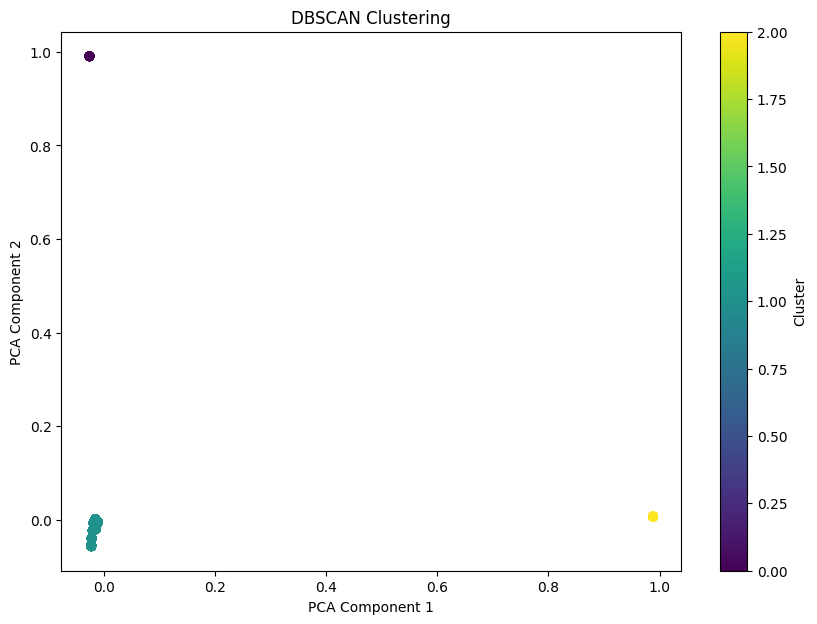

In [8]:
plt.figure(figsize=(10, 7))
plt.scatter(data['x'], data['y'], c=data['cluster'], cmap='viridis', marker='o')
plt.title('DBSCAN Clustering')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.show()

In [10]:
# Выделение слов по кластерам
for cluster in set(clusters):
    print(f"Cluster {cluster}:")
    cluster_texts = [lemma_df['word'][i] for i in range(len(clusters)) if clusters[i] == cluster]
    print(cluster_texts)

Cluster 0:
['россия', 'россия', 'россия', 'россия', 'россия', 'россия', 'россия', 'россия', 'россия', 'россия', 'россия', 'россия', 'россия', 'россия', 'россия', 'россия', 'россия', 'россия', 'россия', 'россия', 'россия', 'россия', 'россия', 'россия', 'россия', 'россия', 'россия', 'россия', 'россия', 'россия', 'россия', 'россия', 'россия', 'россия', 'россия', 'россия', 'россия', 'россия', 'россия', 'россия', 'россия', 'россия', 'россия', 'россия', 'россия', 'россия', 'россия', 'россия', 'россия', 'россия', 'россия', 'россия', 'россия', 'россия', 'россия', 'россия', 'россия', 'россия', 'россия', 'россия', 'россия', 'россия', 'россия', 'россия', 'россия', 'россия', 'россия', 'россия', 'россия']
Cluster 1:
['повышать', 'минимальный', 'размер', 'оплата', 'труд', '(\n', 'мрот', ')\n', 'соответствующий', 'закон', 'конец', 'декабрь', 'подписывать', 'президент', 'владимир', 'путин', 'повышение', 'составлять', 'рубль', ',\n', '7.5', 'процент', 'январь', 'федеральный', 'мрот', 'трудоспособный', 

Первый и третий кластеры состоят из множества копий одного слова: первый = "россия", третий = "год". Во второй кластер вошли все оставшиеся слова